In [31]:
import sys
sys.path.append('../src')

from collections import Counter
import localmodule
import functools
from joblib import Memory, Parallel, delayed
from librosa.display import specshow
import math
import music21 as m21
import numpy as np
import os
import scipy

In [114]:
composer_str = "Haydn"
track_str = "op71n2-04"

# Define constants.
J_tm = 10
N = 2**J_tm
n_octaves = 8
midi_octave_offset = 2
quantization = 2.0
xi = 0.4
sigma = 0.16

midis = []

# Parse Kern score with music21.
data_dir = localmodule.get_data_dir()
dataset_name = localmodule.get_dataset_name()
kern_name = "_".join([dataset_name, "kern"])
kern_dir = os.path.join(data_dir, kern_name)
composer_dir = os.path.join(kern_dir, composer_str)
track_name = track_str + ".krn"
track_path = os.path.join(composer_dir, track_name)
score = m21.converter.parse(track_path)
pianoroll_parts = []
n_parts = len(score.parts)
n_semitones = 12 * n_octaves

# Loop over parts to extract piano rolls.
for part_id in range(n_parts):
    part = score.parts[part_id]
    pianoroll_part = np.zeros((n_semitones, N))
    
    # Get the measure offsets
    measure_offset = {}
    for el in part.recurse(classFilter=('Measure')):
        measure_offset[el.measureNumber] = el.offset
    
    # Loop over notes
    for note in part.recurse(classFilter=('Note')):
        note_start = int(math.ceil(
                (measure_offset[note.measureNumber] +\
                 note.offset) *\
            quantization))
        note_end = int(math.ceil((
                measure_offset[note.measureNumber] +\
                note.offset +\
                note.duration.quarterLength) *\
            quantization))
        pianoroll_part[
            note.midi - midi_octave_offset * 12,
            note_start:note_end] = 1
        midis.append(note.midi)
    pianoroll_parts.append(pianoroll_part)
    
# Stack parts into piano roll.
mtrack_pianoroll = np.stack(pianoroll_parts, 2)
pianoroll = mtrack_pianoroll.max(axis=2)

# Setup wavelet filter bank over time.
filterbank = np.zeros((1, N, J_tm))
for j in range(J_tm-1):
    xi_j = xi * 2**(-j)
    sigma_j = sigma * 2**(-j)
    center = xi_j * N
    den = 2 * sigma_j * sigma_j * N * N
    psi = localmodule.morlet(center, den, N, n_periods=4)
    filterbank[0, :, j] = psi
    
# Append scaling function phi (average).
filterbank[0, 0, -1] = 1

# Convolve pianoroll with filterbank.
pianoroll_ft = scipy.fftpack.fft(pianoroll, axis=1)
pianoroll_ft = np.expand_dims(pianoroll_ft, axis=2)
Y_ft = pianoroll_ft * filterbank
Y = scipy.fftpack.ifft(Y_ft, axis=1)

# Re

In [123]:
Y_chroma = np.reshape(Y, (12, -1, Y.shape[1], Y.shape[2]), 'F')

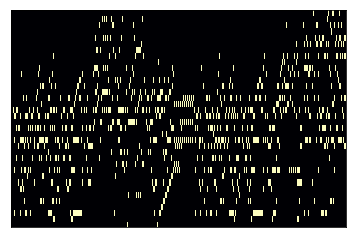

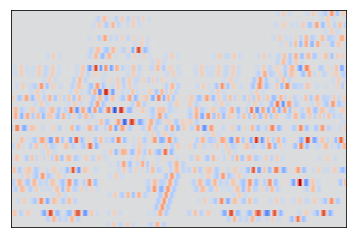

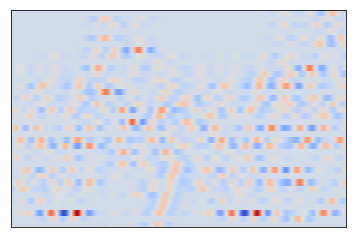

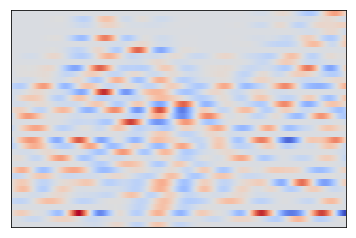

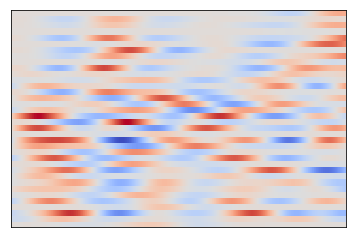

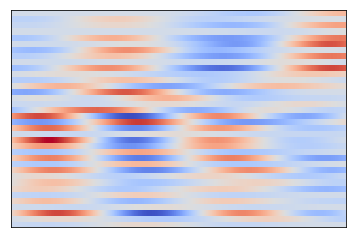

In [117]:
plt.figure()
specshow(pianoroll[24:60, :512])
for j in range(3, 8):
    plt.figure()
    specshow(np.real(Y[24:60, :512, j]))


In [172]:
# Construct eigen-arpeggios
cosine_basis = np.array([[np.cos(2*np.pi*omega*t/3) for omega in range(3)] for t in range(3)]).T
sine_basis = np.array([[np.sin(2*np.pi*omega*t/3) for omega in range(3)] for t in range(3)]).T
fourier_basis = cosine_basis + np.complex(0, 1) * sine_basis
major_template = [0, 4, 7]
minor_template = [0, 3, 7]
major_eigenarpeggios = np.zeros((12, 3), dtype=np.complex)
minor_eigenarpeggios = np.zeros((12, 3), dtype=np.complex)

for omega in range(3):
    for t, p in enumerate(major_template):
        major_eigenarpeggios[p, omega] = fourier_basis[t, omega]
    for t, p in enumerate(minor_template):
        minor_eigenarpeggios[p, omega] = fourier_basis[t, omega]
        
eigenarpeggios = np.stack(
    (major_eigenarpeggios, minor_eigenarpeggios), axis=1)



eigenarpeggios_ft = scipy.fftpack.fft(eigenarpeggios, axis=0)

In [181]:
eigenarpeggios_ft.shape

(12, 2, 3)

In [143]:
sine_basis

array([[ 0.       ,  0.       ,  0.       ],
       [ 0.       ,  0.8660254, -0.8660254],
       [ 0.       , -0.8660254,  0.8660254]])

In [148]:
minor_template

[1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0]